# Importance sampling with feedforward neural networks


In [1]:
import sys
import time

import pandas as pd

import numpy as np
from numpy import savetxt, loadtxt

import matplotlib.pyplot as plt

from scipy import integrate
from scipy.stats import norm

from tqdm.notebook import trange
from cycler import cycler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers, regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Subtract, Multiply, Concatenate, Dot
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

np.random.seed(2023)
tf.random.set_seed(2023)


2023-06-02 13:46:07.348606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python version:  3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]
Tensorflow version:  2.10.0
Keras version:  2.10.0


In [2]:
N_train = 250       # Number of time steps for training
N_test = 250        # Number of time steps for testing

################################################################################

n_hidden = 1          # Number of hidden layers for deep neural network
n_nodes = 5           # Number of nodes in hidden layers
batchsize = 1024      # Batch size
learningrate = 1.0e-3 # Learning rate for Adam (standard 1e-3)

N_NN_train = int(2 * 100 * batchsize) # int(2 * 1000 * batchsize) # Size of training/validation data set for neural network
N_NN_test = int(1.0e5)                 # Size of testing data set for neural network

################################################################################
##### Further model parameters

T = 1           # Terminal time

X0 = 50         # Initial price of asset
mu = 0.05       # Appreciation rate

strike = 70.0   # Strike for the call option

V0 = 0.04
kappa = 2
theta = 0.09
xi = 0.2

rho_base = - 0.5

amplitude = 1
frequency = 4

################################################################################

delta_t_train = T/N_train         # Time increments for training
delta_t_test = T/N_test           # Time increments for testing

t_train = np.linspace(0, T, N_train+1)
t_test = np.linspace(0, T, N_test+1)


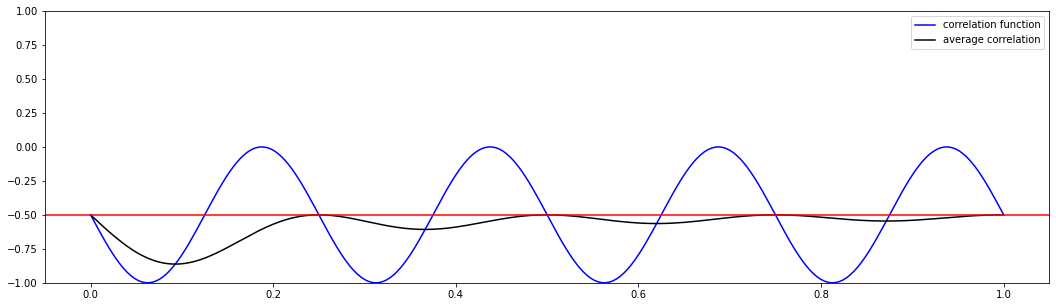

In [3]:
################################################################################
##### Defining correlation function

def cor_func(x):
    return rho_base + amplitude * rho_base * np.sin(2*np.pi*frequency*x)

rho_dyn = np.empty((N_test+1))

for i in range(N_test+1):
    rho_dyn[i] = cor_func(t_test[i])
    
cor_dyn = rho_base * np.ones((N_test+1))

for i in range(1, N_test+1):
    cor_dyn[i] = integrate.quad(cor_func, t_test[0], t_test[i])[0] / t_test[i]

plt.figure(figsize=(18, 5))

plt.plot(t_test, rho_dyn, color='b', label='correlation function')
plt.plot(t_test, cor_dyn, color='k', label='average correlation')
plt.ylim([-1, 1])
plt.legend()
plt.axhline(y=-0.5, color='r')

plt.show()


## Plotting sample path

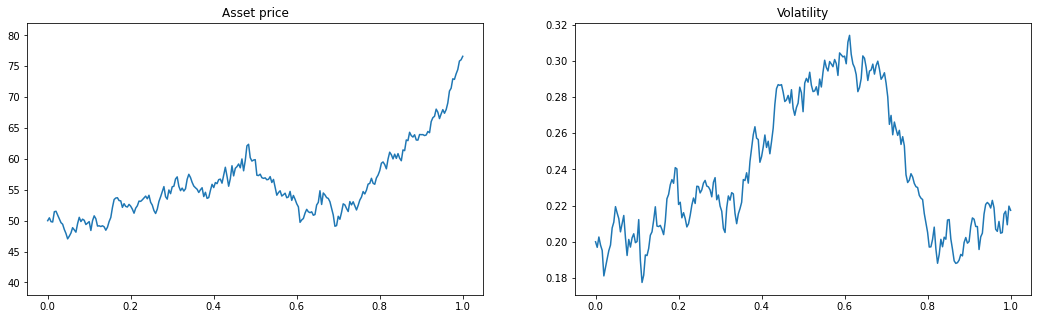

In [4]:
########################################
### SIMULATE PATH OF DYNAMICALL CORRELATED HESTON MODEL

X = np.empty((2, N_test+1))

X[:, 0] = np.array([X0, V0])

for i in range(N_test):
    
    ### Variance-covariance matrix
    Sigma = np.array([[1, xi * cor_func(t_test[i])], 
                      [xi * cor_func(t_test[i]), xi ** 2 * 1]])

    ### Cholesky decomposition of Sigma
    L = np.linalg.cholesky(Sigma)
    
    ### Simulate correlated increment
    increment = np.dot(L, np.random.normal(0, np.sqrt(delta_t_test), (2)))
    
    X[0, i+1] = X[0, i] + mu * X[0, i] * delta_t_test + np.sqrt(X[1, i]) * X[0, i] * increment[0]
    X[1, i+1] = X[1, i] + kappa * (theta - X[1, i]) * delta_t_test + np.sqrt(X[1, i]) * increment[1]

    X[1, i+1] = np.max([0, X[1, i+1]])

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(t_test, X[0, :])
ax[0].set_title("Asset price")

xlim_lower = np.floor(np.min(X[0, :])/10)*10 - 2
xlim_upper = np.ceil(np.max(X[0, :])/10)*10 + 2

ax[0].set_ylim([xlim_lower, xlim_upper])

ax[1].plot(t_test, np.sqrt(X[1, :]))
ax[1].set_title("Volatility")

xlim_lower = np.floor(np.min(np.sqrt(X[1, :])) * 10) / 10 - 0.02
xlim_upper = np.ceil(np.max(np.sqrt(X[1, :])) * 10) / 10 + 0.02

plt.show()


## Computing option price

In [5]:
start_time = time.time()

N_sample = N_NN_test

X = np.empty((N_sample, N_test+1))
V = np.empty((N_sample, N_test+1))

X[:, 0] = X0
V[:, 0] = V0

for i in range(N_test):
    
    incr_X = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_sample))
    
    incr_V_prime = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_sample))
    incr_V = xi * (cor_func(t_test[i]) * incr_X + np.sqrt(1 - cor_func(t_test[i])**2) * incr_V_prime)
    
    drift_X = mu * X[:, i] * delta_t_test
    diffusion_X_prime = np.multiply(np.sqrt(V[:, i]) , X[:, i])
    diffusion_X = np.multiply(diffusion_X_prime, incr_X)
    
    X[:, i+1] = X[:, i] + drift_X + diffusion_X
    
    drift_V = kappa * (theta*np.ones((N_sample)) - V[:, i]) * delta_t_test
    diffusion_V = np.multiply(np.sqrt(V[:, i]), incr_V)
    
    V[:, i+1] = np.maximum(np.zeros((N_sample)), V[:, i] + drift_V + diffusion_V)

average = np.sum(X[:, :N_test] * delta_t_test, axis=1)/T
payoffs = 100 * np.clip(average-strike, 0, None)
counter = np.sum(average-strike >= 0)

elapsed_time = time.time() - start_time

mean_mc = np.mean(payoffs)
var_MC = np.var(payoffs)
stderr_mc = np.std(payoffs) / np.sqrt(N_NN_test)
second_moment_mc = np.mean(np.power(payoffs, 2))

print("Computing time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("========================================")

print("Mean (MC): ", np.around(mean_mc, 4))
print("Second moment (MC): ", np.around(second_moment_mc, 4))
print("Variance (MC): ", np.around(var_MC, 4))

print("========================================")

print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% of mean)")
print("Probability of positive payoff (MC): ", np.around(counter / N_NN_test * 100, 2), "%")
    

Computing time:  00:00:04
Mean (MC):  2.0971
Second moment (MC):  1202.7899
Variance (MC):  1198.3921
Standard error (MC):  0.1095  ( 5.22 % of mean)
Probability of positive payoff (MC):  0.69 %


## Input data for NN training

In [6]:
xtrain = ([np.zeros((N_NN_train))] + # t_0
          [X0 * np.ones((N_NN_train))] + # X_0
          [V0 * np.ones((N_NN_train))] + # V_0
          [np.zeros((N_NN_train))] + # initial value of the payoff
          [np.zeros((N_NN_train, 2))] + # initial value of the first part of the stoch exp
          [np.zeros((N_NN_train))] + # initial value of the second part of the stoch exp
          [np.sqrt(delta_t_train) *  np.random.normal(0, 1, (N_NN_train, 2)) for i in range(N_train)])

ytrain = np.zeros((N_NN_train))

## Generating neural network

In [7]:
layers = []

layers += [Dense(n_nodes, activation='tanh', trainable=True, input_shape=(1, ))]

for i in range(n_hidden-1):
    layers += [Dense(n_nodes, activation='tanh', trainable=True)]

layers += [Dense(2, activation='linear', trainable=True)]


In [8]:
t_0 = Input(shape=(1, ))
X_0 = Input(shape=(1, ))
V_0 = Input(shape=(1, ))

c_0 = Input(shape=(1, ))
c_1 = Input(shape=(2, ))
c_2 = Input(shape=(1, ))

inputs = [t_0]+[X_0]+[V_0]+[c_0]+[c_1]+[c_2]

t_current = t_0
X_current = X_0
V_current = V_0

for j in range(N_train):
    
    helper_b = X_current * delta_t_train
    c_0 = Add()([c_0, helper_b])
    
    strategy = t_current
    for i in range(n_hidden+1):
        strategy = layers[i](strategy)
    
    incr_B = Input(shape=(2, ))
    inputs = inputs + [incr_B]
    
    Sigma = np.array([[1, xi * cor_func(t_train[j])], [xi * cor_func(t_train[j]), xi ** 2 * 1]])
    L = np.linalg.cholesky(Sigma)
    
    incr_M = incr_B @ tf.linalg.matrix_transpose(K.constant(L))
    
    first_half, second_half = tf.split(incr_M, 2, axis = 1)
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = strategy @ tf.linalg.matrix_transpose(K.constant(Sigma))
    helper_e3 = Dot(axes=1)([strategy, helper_e2]) * delta_t_train
    c_2 = Add()([c_2, helper_e3])
    
    t_current = t_current + delta_t_train
    
    helper_x0 = mu * X_current * delta_t_train
    
    helper_x1 = Multiply()([K.sqrt(V_current), X_current])
    helper_x2 = Multiply()([helper_x1, first_half])
    
    helper_x3 = Add()([helper_x0, helper_x2])
    X_current = Add()([X_current, helper_x3])
    
    helper_v0 = kappa * (theta - V_current) * delta_t_train
    
    helper_v1 = Multiply()([K.sqrt(V_current), second_half])   
    
    helper_v2 = Add()([helper_v1, helper_v0])
    V_current = Add()([V_current, helper_v2])
    V_current = K.relu(V_current)
    
helper_y1 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_y2 = 0.25 * c_2
helper_y3 = Add()([helper_y1, helper_y2])
helper_y4 = Lambda(lambda x: K.exp(x))(helper_y3)

payoff = 100 * Lambda(lambda x: K.relu(x-strike))(c_0)
payoff_adjusted = Multiply()([payoff, helper_y4])

outputs = [payoff_adjusted]


2023-06-02 13:46:22.085851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
opt = optimizers.Adam(learning_rate = learningrate)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=opt, loss='mean_squared_error')

In [10]:
indices_list = []

for i in range(len(model.layers)):
    layer_train_size = len(model.layers[i].get_weights())
    if layer_train_size > 0:
        indices_list += [i]

## Training the neural network

In [11]:
stopping_rule = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=1, 
                              restore_best_weights=True)

In [12]:
start_time = time.time()

history = model.fit(x=xtrain,
                    y=ytrain,
                    epochs=1000,
                    verbose=1,
                    shuffle=True,
                    batch_size=batchsize,
                    validation_split=0.5,
                    callbacks=[stopping_rule])

elapsed_time = time.time() - start_time

Epoch 1/1000
100/100 [==============================] - 84s 308ms/step - loss: 701.1459 - val_loss: 494.5949
Epoch 2/1000
100/100 [==============================] - 7s 68ms/step - loss: 387.8694 - val_loss: 326.1497
Epoch 3/1000
100/100 [==============================] - 6s 63ms/step - loss: 268.6051 - val_loss: 239.4273
Epoch 4/1000
100/100 [==============================] - 6s 65ms/step - loss: 202.5906 - val_loss: 185.0786
Epoch 5/1000
100/100 [==============================] - 6s 64ms/step - loss: 161.8256 - val_loss: 150.8363
Epoch 6/1000
100/100 [==============================] - 6s 64ms/step - loss: 134.9251 - val_loss: 126.8898
Epoch 7/1000
100/100 [==============================] - 7s 70ms/step - loss: 115.9907 - val_loss: 110.3607
Epoch 8/1000
100/100 [==============================] - 7s 69ms/step - loss: 102.2234 - val_loss: 97.9358
Epoch 9/1000
100/100 [==============================] - 7s 71ms/step - loss: 91.7978 - val_loss: 88.1769
Epoch 10/1000
100/100 [===============

100/100 [==============================] - 9s 94ms/step - loss: 10.8186 - val_loss: 11.0477
Epoch 79/1000
100/100 [==============================] - 9s 95ms/step - loss: 10.7666 - val_loss: 10.9698
Epoch 80/1000
100/100 [==============================] - 9s 91ms/step - loss: 10.7102 - val_loss: 10.8992
Epoch 81/1000
100/100 [==============================] - 8s 82ms/step - loss: 10.6627 - val_loss: 10.8254
Epoch 82/1000
100/100 [==============================] - 7s 71ms/step - loss: 10.6180 - val_loss: 10.7563
Epoch 83/1000
100/100 [==============================] - 8s 80ms/step - loss: 10.5707 - val_loss: 10.6920
Epoch 84/1000
100/100 [==============================] - 6s 65ms/step - loss: 10.5270 - val_loss: 10.6283
Epoch 85/1000
100/100 [==============================] - 6s 64ms/step - loss: 10.4911 - val_loss: 10.5809
Epoch 86/1000
100/100 [==============================] - 6s 62ms/step - loss: 10.4526 - val_loss: 10.5115
Epoch 87/1000
100/100 [==============================] - 6s 

In [13]:
model_best = keras.Sequential()
model_best.add(Dense(n_nodes, activation='tanh', input_shape=(1, )))

for i in range(n_hidden-1):
    model_best.add(Dense(n_nodes, activation='tanh'))

model_best.add(Dense(2, activation='linear'))
model_best.build()

count = 0
for j in indices_list:
    model_best.layers[count].set_weights(model.layers[j].get_weights())
    count += 1

## Some visualizations

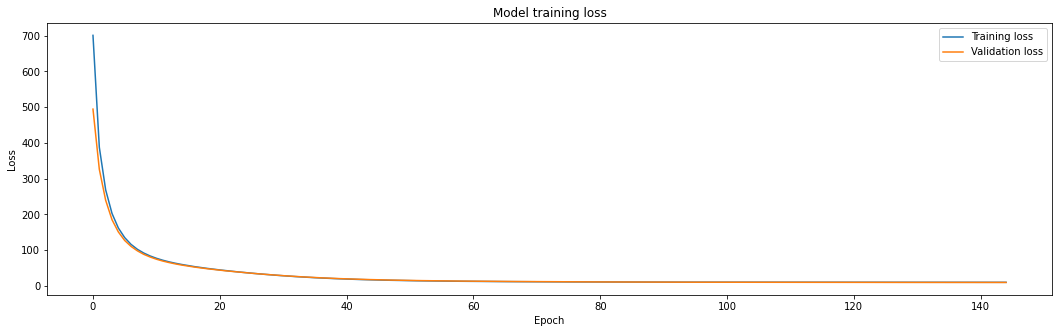

In [14]:
plt.figure(figsize=(18, 5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.yscale('log')

plt.show()

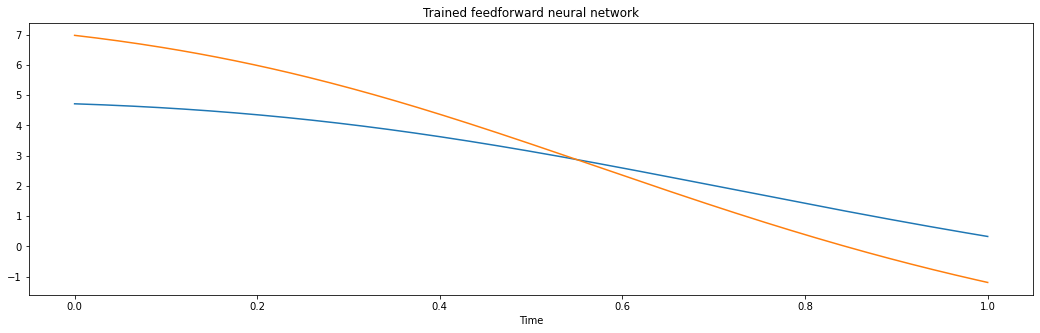

In [15]:
learnedstrat = model_best.predict(t_test, verbose = 0)

plt.figure(figsize=(18, 5))
plt.plot(t_test, learnedstrat)
plt.title("Trained feedforward neural network")
plt.xlabel("Time")
plt.show()


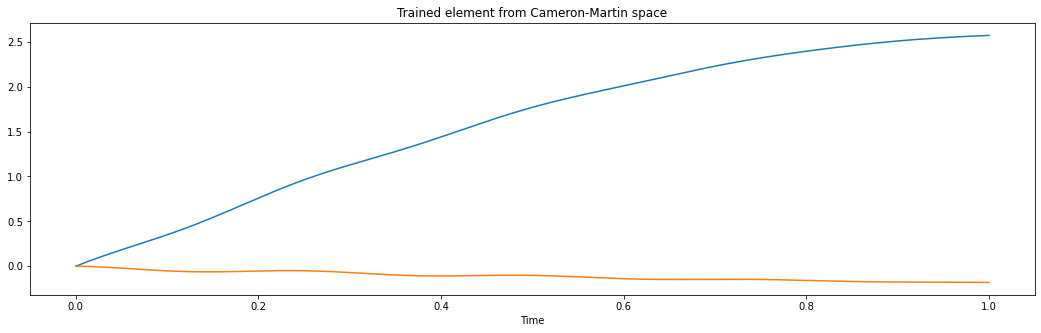

In [16]:
# Visualizing the drift

normdrift = 0
driftdummy = np.zeros((2))
drift = np.zeros((2, N_test+1))
driftdelta = np.zeros((2, N_test))

for j in range(N_test):
    
    Sigma = np.array([[1, xi * cor_func(t_test[j])], [xi * cor_func(t_test[j]), xi ** 2 * 1]])
    
    normdrift += np.dot(np.transpose(learnedstrat[j,:]), np.dot(Sigma, learnedstrat[j,:])) * delta_t_test
    driftdelta[:, j] = np.dot(Sigma, learnedstrat[j,:]) * delta_t_test
    driftdummy += np.dot(Sigma, learnedstrat[j,:]) * delta_t_test
    drift[:, j+1] = driftdummy

plt.figure(figsize=(18, 5))

plt.plot(t_test, np.transpose(drift))
plt.title("Trained element from Cameron-Martin space")
plt.xlabel("Time")
plt.show()


## Computing option prices (MC, IS, Strat)

In [17]:
N_sample = N_NN_test

X_MC = np.empty((N_sample, N_test+1))
V_MC = np.empty((N_sample, N_test+1))

X_IS = np.empty((N_sample, N_test+1))
V_IS = np.empty((N_sample, N_test+1))

X_MC[:, 0] = X0
V_MC[:, 0] = V0

X_IS[:, 0] = X0
V_IS[:, 0] = V0

C0 = np.zeros((N_sample))

for i in range(N_test):
    
    incr_X = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_sample))
    
    incr_V_prime = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_sample))
    incr_V = xi * (cor_func(t_test[i]) * incr_X + np.sqrt(1 - cor_func(t_test[i])**2) * incr_V_prime)
    
    ########## Plain Monte Carlo
    
    drift_X = mu * X_MC[:, i] * delta_t_test
    diffusion_X_prime = np.multiply(np.sqrt(V_MC[:, i]) , X_MC[:, i])
    diffusion_X = np.multiply(diffusion_X_prime, incr_X)
    
    X_MC[:, i+1] = X_MC[:, i] + drift_X + diffusion_X
    
    drift_V = kappa * (theta*np.ones((N_sample)) - V_MC[:, i]) * delta_t_test
    diffusion_V = np.multiply(np.sqrt(V_MC[:, i]), incr_V)
    
    V_MC[:, i+1] = np.maximum(np.zeros((N_sample)), V_MC[:, i] + drift_V + diffusion_V)
    
    ########## Plain Monte Carlo + deep importance sampling
    
    incr_X_IS = incr_X + driftdelta[0, i]
    incr_V_IS = incr_V + driftdelta[1, i]
    
    drift_X = mu * X_IS[:, i] * delta_t_test
    diffusion_X_prime = np.multiply(np.sqrt(V_IS[:, i]) , X_IS[:, i])
    diffusion_X = np.multiply(diffusion_X_prime, incr_X_IS)
    
    X_IS[:, i+1] = X_IS[:, i] + drift_X + diffusion_X
    
    drift_V = kappa * (theta*np.ones((N_sample)) - V_IS[:, i]) * delta_t_test
    diffusion_V = np.multiply(np.sqrt(V_IS[:, i]), incr_V_IS)
    
    V_IS[:, i+1] = np.maximum(np.zeros((N_sample)), V_IS[:, i] + drift_V + diffusion_V)
    
    C0 = C0 - learnedstrat[i, 0] * incr_X - learnedstrat[i, 1] * incr_V
    
average_MC = np.sum(X_MC[:, :N_test] * delta_t_test, axis=1)/T
payoffs_MC = 100 * np.clip(average_MC-strike, 0, None)
counter_MC = np.sum(average_MC-strike >= 0)

average_IS = np.sum(X_IS[:, :N_test] * delta_t_test, axis=1)/T
adjustment = np.exp(C0 - 0.5 * normdrift)
payoffs_IS = 100 * np.clip(average_IS-strike, 0, None) * adjustment
counter_IS = np.sum(average_IS-strike >= 0)

mean_MC = np.mean(payoffs_MC)
var_MC = np.var(payoffs_MC)
stderr_MC = np.std(payoffs_MC) / np.sqrt(N_NN_test)
second_moment_MC = np.mean(np.power(payoffs_MC, 2))

mean_IS = np.mean(payoffs_IS)
var_IS = np.var(payoffs_IS)
stderr_IS = np.std(payoffs_IS) / np.sqrt(N_NN_test)
second_moment_IS = np.mean(np.power(payoffs_IS, 2))

variance_ratio = np.var(payoffs_MC) / np.var(payoffs_IS)


## Experimental stratification part

In [18]:
N_strata = 100

N_replications = int(N_NN_test / N_strata)

DATA_test_Strat_X = np.zeros((N_NN_test, N_test))
DATA_test_Strat_V = np.zeros((N_NN_test, N_test))

driftdelta_concatenated = np.concatenate([driftdelta[0, :], driftdelta[1, :]])
driftdelta_scaled = driftdelta_concatenated / np.sqrt(delta_t_test)
u = driftdelta_scaled / np.sqrt(driftdelta_scaled.dot(driftdelta_scaled))

for i in range(N_strata):
    
    M_random = np.random.normal(0, 1, (N_replications, 2*N_test))
    V_master = np.random.uniform(0, 1, (N_replications))
    
    V = i / N_strata + V_master / N_strata
    V = norm.ppf(V)
    
    Y = M_random
    
    sum_1 = np.multiply(np.ones((N_replications, 2*N_test))*u, V[:, None])
    sum_2 = Y
    sum_3 = np.multiply(np.ones((N_replications, 2*N_test))*u, Y.dot(u)[:, None])
    
    Z = sum_1 + sum_2 - sum_3
    
    DATA_test_Strat_X[(i*N_replications):((i+1)*N_replications), :] = Z[:, 0:N_test]
    DATA_test_Strat_V[(i*N_replications):((i+1)*N_replications), :] = Z[:, N_test:]

In [19]:
### Stratification estimate

means_SS = []
variances_SS = []
counter_SS = 0

for j in range(N_strata):
    
    X_SS = np.empty((N_replications, N_test+1))
    V_SS = np.empty((N_replications, N_test+1))
    
    X_SS[:, 0] = X0
    V_SS[:, 0] = V0
    
    C0 = np.zeros((N_replications))
    
    for i in range(N_test):
        
        Z1 = DATA_test_Strat_X[(j*N_replications):((j+1)*N_replications), i]
        Z2 = DATA_test_Strat_V[(j*N_replications):((j+1)*N_replications), i]
        
        incr_X = np.sqrt(delta_t_test) * Z1
        incr_V_prime = np.sqrt(delta_t_test) * Z2
        incr_V = xi * (cor_func(t_test[i]) * incr_X + np.sqrt(1 - cor_func(t_test[i])**2) * incr_V_prime)
    
        incr_X_SS = incr_X + driftdelta[0, i]
        incr_V_SS = incr_V + driftdelta[1, i]
    
        drift_X = mu * X_SS[:, i] * delta_t_test
        diffusion_X_prime = np.multiply(np.sqrt(V_SS[:, i]) , X_SS[:, i])
        diffusion_X = np.multiply(diffusion_X_prime, incr_X_SS)
    
        X_SS[:, i+1] = X_SS[:, i] + drift_X + diffusion_X
    
        drift_V = kappa * (theta*np.ones((N_replications)) - V_SS[:, i]) * delta_t_test
        diffusion_V = np.multiply(np.sqrt(V_SS[:, i]), incr_V_SS)
    
        V_SS[:, i+1] = np.maximum(np.zeros((N_replications)), V_SS[:, i] + drift_V + diffusion_V)
    
        C0 = C0 - learnedstrat[i, 0] * incr_X - learnedstrat[i, 1] * incr_V
    
    average_SS = np.sum(X_SS[:, :N_test] * delta_t_test, axis=1)/T
    adjustment = np.exp(C0 - 0.5 * normdrift)
    payoffs_SS = 100 * np.clip(average_SS-strike, 0, None) * adjustment
    counter_SS += np.sum(average_SS-strike >= 0)
    
    means_SS = means_SS + [np.mean(payoffs_SS)]
    variances_SS = variances_SS + [np.var(payoffs_SS)]
    
mean_SS = 0
variance_SS = 0

for i in range(N_strata):
    mean_SS += 1/N_strata * means_SS[i]
    variance_SS = variance_SS + (1/N_strata)**2 * variances_SS[i] / N_replications

call_SS = mean_SS
variance_ratio_SS = np.var(payoffs_MC) / N_NN_test / variance_SS

counter_SS = counter_SS / N_NN_test * 100
    

In [20]:
### RESULTS 

print("========================================")

print("MC estimate: ", np.around(np.mean(payoffs_MC), 8))
print("IS estimate: ", np.around(np.mean(payoffs_IS), 8))
print("SS estimate: ", np.around(call_SS, 8))

print("========================================")

print("Standard error (MC): ", np.around(np.std(payoffs_MC) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(payoffs_MC) / np.sqrt(N_NN_test) / np.mean(payoffs_MC) * 100, 8), "% )")
print("Standard error (IS): ", np.around(np.std(payoffs_IS) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(payoffs_IS) / np.sqrt(N_NN_test) / np.mean(payoffs_IS) * 100, 8), "% )")
print("Standard error (SS): ", np.around(np.sqrt(variance_SS), 8), " (", np.around(np.sqrt(variance_SS) / np.sqrt(N_NN_test) / call_SS * 100, 8), "% )")

print("========================================")

print("Variance ratio IS: ", np.around(variance_ratio))
print("Variance ratio SS: ", np.around(variance_ratio_SS))

print("========================================")

print("Probability of positive payoff (MC): ", np.around(counter_MC / N_sample * 100, 4), "%")
print("Probability of positive payoff (IS): ", np.around(counter_IS / N_sample * 100, 4), "%")
print("Probability of positive payoff (SS): ", np.around(counter_SS, 4), "%")


MC estimate:  1.74506086
IS estimate:  1.92223473
SS estimate:  1.91600315
Standard error (MC):  0.09790488  ( 5.61039943 % )
Standard error (IS):  0.00752892  ( 0.39167526 % )
Standard error (SS):  0.0055675  ( 0.00091889 % )
Variance ratio IS:  169.0
Variance ratio SS:  309.0
Probability of positive payoff (MC):  0.655 %
Probability of positive payoff (IS):  64.737 %
Probability of positive payoff (SS):  64.632 %
